In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
from glob import glob
import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import keras_tuner as kt   # keras_tuner hỗ trợ tf.keras 
from tensorflow.keras import Sequential, Model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.layers import Input, Dropout, Dense, Layer, LayerNormalization, MultiHeadAttention, Conv2D, BatchNormalization, Flatten, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import EfficientNetB0

In [2]:
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

def get_efficientnet_model(num_classes=1, input_shape=(32, 32, 3)):
    """
    Tạo model EfficientNetB0 cho binary classification
    """
    # Load EfficientNetB0 với pretrained weights
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Thêm classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='sigmoid')(x)
    
    model = Model(inputs=base_model.input, outputs=outputs)
    
    return model

C:\Users\hp\AppData\Local\Temp\ipykernel_2040\927846416.py:58: DtypeWarning: Columns (7,12,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('metadata.csv')


Train size: 34603
Validation size: 4450
Test size: 10381
train 34603 validation 4450 test 10381 test_diagnosis_processed 10381


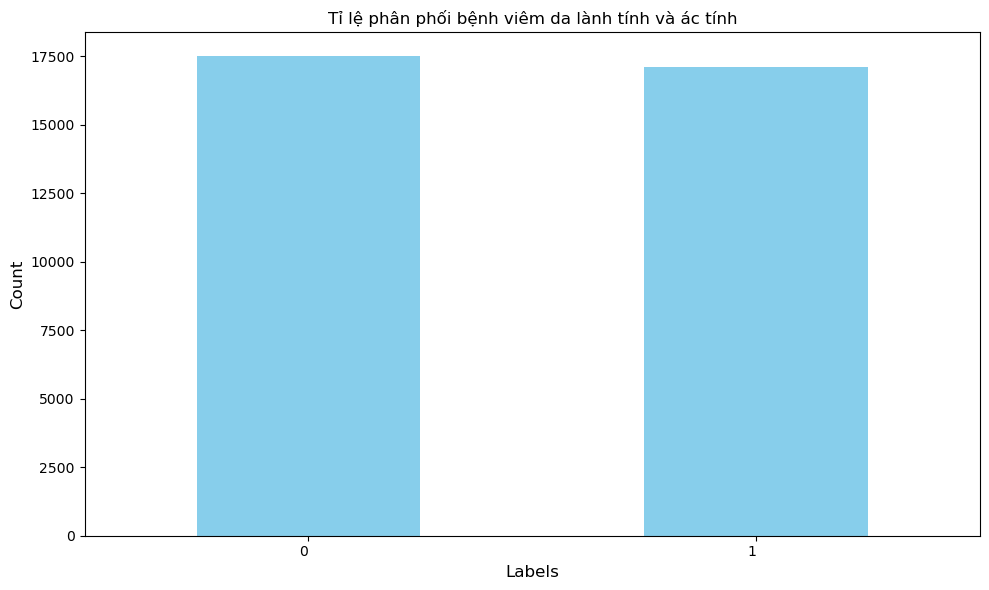

In [5]:
train_data_dir = '../Dataset_Final/train/'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        fpath = fpath.replace("\\", "/")
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

train_df = pd.concat([Fseries, Lseries], axis= 1)
test_data_dir = '../Dataset_Final/test/'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        fpath = fpath.replace("\\", "/")
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([Fseries, Lseries], axis= 1)
train_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
val_data_dir = '../Dataset_Final/val/'
filepaths = []
labels = []
folds = os.listdir(val_data_dir)
for fold in folds:
    foldpath = os.path.join(val_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        fpath = fpath.replace("\\", "/")
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
valid_df = pd.concat([Fseries, Lseries], axis= 1)
train_df = pd.concat([train_df, valid_df], axis=0, ignore_index=True)
df = pd.read_csv('metadata.csv')
df
df['diagnosis_processed'] = df['diagnosis_processed'].apply(lambda x: 0 if x == 'Benign' else 1)
train_df = df[df['dataset_split'] == 'train']  
valid_df = df[df['dataset_split'] == 'val'] 
test_df = df[df['dataset_split'] == 'test']  
print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(valid_df)}")
print(f"Test size: {len(test_df)}")
test_labels = test_df['diagnosis_processed'].values 
print('train', train_df.shape[0], 'validation', valid_df.shape[0], 'test', test_df.shape[0],'test_diagnosis_processed', test_labels.shape[0])
label_counts = train_df['diagnosis_processed'].value_counts()
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color= 'skyblue')
plt.title('Tỉ lệ phân phối bệnh viêm da lành tính và ác tính')
plt.xlabel('Labels', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0, ha='right')
plt.tight_layout()
plt.show()

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Kích thước ảnh cho DenseNet
IMG_SIZE = (32, 32)  # DenseNet yêu cầu 224x224
TRAIN_BATCH_SIZE = 32
VALID_TEST_BATCH_SIZE = 32

train_dir = '../Dataset_Final/train/'
valid_dir = '../Dataset_Final/val/'
test_dir = '../Dataset_Final/test/'

# Data generator cho training với augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

# Data generator cho validation và test (chỉ rescale)
valid_test_datagen = ImageDataGenerator(rescale=1./255)

# Cập nhật generators với kích thước mới
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=TRAIN_BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True,
    seed=42
)
valid_gen = valid_test_datagen.flow_from_directory(
    valid_dir,
    target_size=IMG_SIZE,
    batch_size=VALID_TEST_BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)
test_gen = valid_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=VALID_TEST_BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)
# Kiểm tra kết quả
print("Training generator:")
print(f"Classes: {train_gen.class_indices}")
print(f"Samples: {train_gen.samples}")
print(f"Batch size: {train_gen.batch_size}")
print(f"Number of batches: {len(train_gen)}")
print("\n")

print("Validation generator:")
print(f"Classes: {valid_gen.class_indices}")
print(f"Samples: {valid_gen.samples}")
print(f"Batch size: {valid_gen.batch_size}")
print(f"Number of batches: {len(valid_gen)}")
print("\n")

print("Test generator:")
print(f"Classes: {test_gen.class_indices}")
print(f"Samples: {test_gen.samples}")
print(f"Batch size: {test_gen.batch_size}")
print(f"Number of batches: {len(test_gen)}")
# Kiểm tra kết quả
print("Training generator:")
print(f"Classes: {train_gen.class_indices}")
print(f"Samples: {train_gen.samples}")
print(f"Batch size: {train_gen.batch_size}")
print(f"Number of batches: {len(train_gen)}")

Found 34603 images belonging to 2 classes.
Found 4450 images belonging to 2 classes.
Found 10381 images belonging to 2 classes.
Training generator:
Classes: {'Benign': 0, 'Malignant': 1}
Samples: 34603
Batch size: 32
Number of batches: 1082


Validation generator:
Classes: {'Benign': 0, 'Malignant': 1}
Samples: 4450
Batch size: 32
Number of batches: 140


Test generator:
Classes: {'Benign': 0, 'Malignant': 1}
Samples: 10381
Batch size: 32
Number of batches: 325
Training generator:
Classes: {'Benign': 0, 'Malignant': 1}
Samples: 34603
Batch size: 32
Number of batches: 1082


In [7]:
# Đếm số lượng mẫu cho mỗi class trong training
if hasattr(train_gen, 'classes'):
    train_classes = train_gen.classes
    unique, counts = np.unique(train_classes, return_counts=True)
    print("Samples per class:")
    for class_idx, count in zip(unique, counts):
        class_name = [name for name, idx in train_gen.class_indices.items() if idx == class_idx][0]
        print(f"  {class_name}: {count}")
print("\n")

print("Validation generator:")
print(f"Classes: {valid_gen.class_indices}")
print(f"Samples: {valid_gen.samples}")
print(f"Batch size: {valid_gen.batch_size}")
print(f"Number of batches: {len(valid_gen)}")

if hasattr(valid_gen, 'classes'):
    valid_classes = valid_gen.classes
    unique, counts = np.unique(valid_classes, return_counts=True)
    print("Samples per class:")
    for class_idx, count in zip(unique, counts):
        class_name = [name for name, idx in valid_gen.class_indices.items() if idx == class_idx][0]
        print(f"  {class_name}: {count}")
print("\n")

print("Test generator:")
print(f"Classes: {test_gen.class_indices}")
print(f"Samples: {test_gen.samples}")
print(f"Batch size: {test_gen.batch_size}")
print(f"Number of batches: {len(test_gen)}")

Samples per class:
  Benign: 17500
  Malignant: 17103


Validation generator:
Classes: {'Benign': 0, 'Malignant': 1}
Samples: 4450
Batch size: 32
Number of batches: 140
Samples per class:
  Benign: 2250
  Malignant: 2200


Test generator:
Classes: {'Benign': 0, 'Malignant': 1}
Samples: 10381
Batch size: 32
Number of batches: 325


In [8]:
if hasattr(test_gen, 'classes'):
    test_classes = test_gen.classes
    unique, counts = np.unique(test_classes, return_counts=True)
    print("Samples per class:")
    for class_idx, count in zip(unique, counts):
        class_name = [name for name, idx in test_gen.class_indices.items() if idx == class_idx][0]
        print(f"  {class_name}: {count}")
def process_train_gen(train_gen):
    # Duyệt qua từng batch trong train_gen
    while True:
        x_batch, y_batch = next(train_gen)
      
        yield x_batch, y_batch

def process_valid_test_gen(valid_test_gen):
    # Duyệt qua từng batch trong train_gen
    while True:
        x_batch, y_batch = next(valid_test_gen)
        
        yield x_batch, y_batch

Samples per class:
  Benign: 5250
  Malignant: 5131


In [9]:
train_gen = process_train_gen(train_gen)
valid_gen = process_valid_test_gen(valid_gen)
test_gen = process_valid_test_gen(test_gen)
import math
train_steps = math.ceil(train_df.shape[0] / TRAIN_BATCH_SIZE)
validation_steps = math.ceil(valid_df.shape[0] / VALID_TEST_BATCH_SIZE)
test_steps = math.ceil(test_df.shape[0] / VALID_TEST_BATCH_SIZE)

In [10]:
# Xây dựng model
model = get_efficientnet_model(num_classes=1)

# Optimizer
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=0.0000001, weight_decay=1.9091e-06
)

model.compile(
    optimizer=optimizer, 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 32, 32, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 32, 32, 3)         │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 32, 32, 3)         │               7 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_1 (Rescaling)       │ (None, 32, 32, 3)         │               0 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 33, 33, 3)         │               0 │ rescaling_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 16, 16, 32)        │             864 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 16, 16, 32)        │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 16, 16, 32)        │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 16, 16, 32)        │             288 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 16, 16, 32)        │             128 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 16, 16, 32)        │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 32)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 32)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 8)           │             264 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 32)          │             288 │ block1a_se_reduce[0][0]    │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 4,008,829 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [11]:
weight_path = "{}_weights.best.weights.h5".format('deepderma_efficientnet')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only=True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5)

reduce = ReduceLROnPlateau(
        monitor="val_loss", factor=0.1,
        patience=2, verbose=1
    )

# Thêm CSVLogger vào callbacks_list
csv_logger = CSVLogger('training_logger_v3_efficientnet.csv', separator=',', append=False)

callbacks_list = [checkpoint, early, reduce, csv_logger]

In [12]:
# load the best weights
model.load_weights('deepderma_efficientnet_weights.best.weights.h5')

C:\Users\hp\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 428 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [14]:
history = model.fit(train_gen,  
            steps_per_epoch=train_steps,
            validation_data=valid_gen,  
            validation_steps=validation_steps,
            epochs=100,
            callbacks=callbacks_list
           )

Epoch 1/100
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 764ms/step - accuracy: 0.7523 - loss: 0.5211
Epoch 1: val_loss improved from inf to 0.49207, saving model to deepderma_efficientnet_weights.best.weights.h5
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 976s 860ms/step - accuracy: 0.7523 - loss: 0.5211 - val_accuracy: 0.7721 - val_loss: 0.4921 - learning_rate: 1.0000e-07
Epoch 2/100
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 728ms/step - accuracy: 0.7530 - loss: 0.5154
Epoch 2: val_loss improved from 0.49207 to 0.49063, saving model to deepderma_efficientnet_weights.best.weights.h5
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 860s 796ms/step - accuracy: 0.7530 - loss: 0.5154 - val_accuracy: 0.7715 - val_loss: 0.4906 - learning_rate: 1.0000e-07
Epoch 3/100
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.7630 - loss: 0.5132
Epoch 3: val_loss did not improve from 0.49063
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 823s 761ms/step - accuracy: 0.7630 - loss: 0.5132 - val_accuracy: 0.7721 - val_loss: 0.4924 - learning_rate: 1.0000e-07
E

In [48]:
# history = model.fit(train_gen,  
#             steps_per_epoch=train_steps,
#             validation_data=valid_gen,  
#             validation_steps=validation_steps,
#             epochs=100,
#             callbacks=callbacks_list
#            )

Epoch 1/100
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7441 - loss: 0.5343
Epoch 1: val_loss improved from inf to 0.50211, saving model to deepderma_efficientnet_weights.best.weights.h5
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 1804s 2s/step - accuracy: 0.7441 - loss: 0.5343 - val_accuracy: 0.7636 - val_loss: 0.5021 - learning_rate: 1.0000e-07
Epoch 2/100
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7476 - loss: 0.5286
Epoch 2: val_loss improved from 0.50211 to 0.50037, saving model to deepderma_efficientnet_weights.best.weights.h5
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 1583s 1s/step - accuracy: 0.7476 - loss: 0.5286 - val_accuracy: 0.7663 - val_loss: 0.5004 - learning_rate: 1.0000e-07
Epoch 3/100
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7492 - loss: 0.5252
Epoch 3: val_loss improved from 0.50037 to 0.50021, saving model to deepderma_efficientnet_weights.best.weights.h5
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 1587s 1s/step - accuracy: 0.7492 - loss: 0.5252 - val_accuracy: 0.

KeyboardInterrupt: 

In [10]:
# history = model.fit(train_gen,  
#             steps_per_epoch=train_steps,
#             validation_data=valid_gen,  
#             validation_steps=validation_steps,
#             epochs=100,
#             callbacks=callbacks_list
#            )

Epoch 1/100
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - accuracy: 0.4861 - loss: 0.8342
Epoch 1: val_loss improved from inf to 0.76673, saving model to deepderma_efficientnet_weights.best.weights.h5
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 878s 767ms/step - accuracy: 0.4861 - loss: 0.8342 - val_accuracy: 0.5470 - val_loss: 0.7667 - learning_rate: 1.0000e-07
Epoch 2/100
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 874ms/step - accuracy: 0.4995 - loss: 0.8141
Epoch 2: val_loss improved from 0.76673 to 0.75859, saving model to deepderma_efficientnet_weights.best.weights.h5
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 1017s 940ms/step - accuracy: 0.4995 - loss: 0.8141 - val_accuracy: 0.5452 - val_loss: 0.7586 - learning_rate: 1.0000e-07
Epoch 3/100
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.5018 - loss: 0.8054
Epoch 3: val_loss improved from 0.75859 to 0.74628, saving model to deepderma_efficientnet_weights.best.weights.h5
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 767s 710ms/step - accuracy: 0.5018 - loss: 0.8054 - 

KeyboardInterrupt: 

In [44]:
import pandas as pd

# Danh sách file theo thứ tự
files = [
    'training_logger_efficientnet.csv',
    'training_logger_v2_efficientnet.csv', 
    'training_logger_v3_efficientnet.csv'
]

# Đọc và gộp tất cả file với epoch liên tục
merged_rows = []
current_epoch = 0

for file in files:
    df = pd.read_csv(file)
    
    # Cập nhật epoch liên tục
    if not df.empty:
        # Giữ nguyên epoch của file đầu tiên
        if len(merged_rows) == 0:
            merged_rows.append(df)
            current_epoch = df['epoch'].max() + 1 if 'epoch' in df.columns else 0
        else:
            # Tăng epoch cho các file sau
            df_copy = df.copy()
            if 'epoch' in df_copy.columns:
                df_copy['epoch'] = df_copy['epoch'] + current_epoch
            merged_rows.append(df_copy)
            current_epoch = df_copy['epoch'].max() + 1

# Gộp tất cả
merged_df = pd.concat(merged_rows, ignore_index=True)

# Lưu file mới
merged_df.to_csv('merged_training_logger_continuous_epoch.csv', index=False)

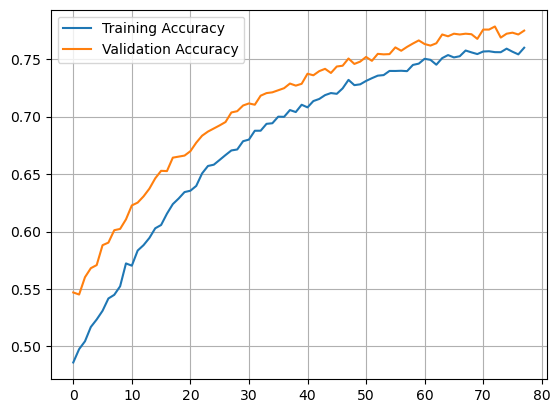

In [66]:
def plot_history_accuracy(csv_file):
    # Đọc dữ liệu từ CSV
    df = pd.read_csv(csv_file)
    
    # Vẽ biểu đồ
    plt.plot(df["accuracy"], label="Training Accuracy")
    plt.plot(df["val_accuracy"], label="Validation Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

plot_history_accuracy('training_logger_efficientnet.csv')

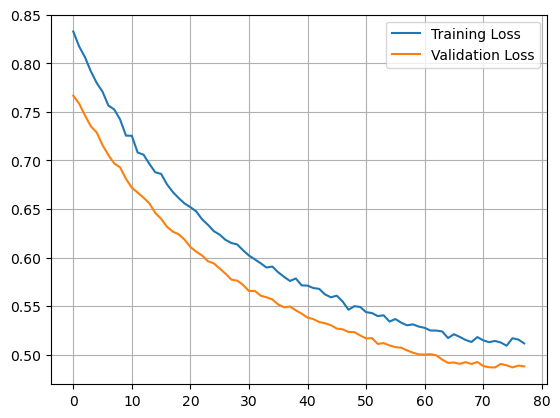

In [68]:
def plot_history_loss(csv_file):
    # Đọc dữ liệu từ CSV
    df = pd.read_csv(csv_file)
    
    # Vẽ biểu đồ
    plt.plot(df["loss"], label="Training Loss")
    plt.plot(df["val_loss"], label="Validation Loss")
    plt.legend()
    plt.grid()
    plt.show()

plot_history_loss('training_logger_efficientnet.csv')

In [24]:
predictions = model.predict(test_gen, steps=test_steps, verbose=True)
predictions = (predictions >= 0.5).astype(int)

325/325 ━━━━━━━━━━━━━━━━━━━━ 279s 849ms/step


In [25]:
# Kiểm tra kích thước
print(f"Test labels shape: {test_labels.shape}")
print(f"Predictions shape: {predictions.shape}")

Test labels shape: (10381,)
Predictions shape: (10381, 1)


In [26]:
# Cắt cho khớp kích thước
min_length = min(len(test_labels), len(predictions))
test_labels = test_labels[:min_length]
predictions = predictions[:min_length]
print(f"After trimming - Test labels: {test_labels.shape}, Predictions: {predictions.shape}")

After trimming - Test labels: (10381,), Predictions: (10381, 1)


In [27]:
# Sau đó mới tính classification report
print(classification_report(test_labels, predictions, target_names=['Benign (Class 0)', 'Malignant (Class 1)']))

                     precision    recall  f1-score   support

   Benign (Class 0)       0.77      0.73      0.75      5250
Malignant (Class 1)       0.73      0.78      0.76      5131

           accuracy                           0.75     10381
          macro avg       0.75      0.75      0.75     10381
       weighted avg       0.75      0.75      0.75     10381



In [28]:
# Classification report dạng dict
report_dict = classification_report(
    test_labels, 
    predictions, 
    target_names=['Benign (Class 0)', 'Malignant (Class 1)'], 
    output_dict=True
)

# Chuyển thành DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# In ra bảng trong notebook
print(report_df)

# Lưu ra file CSV
report_df.to_csv("classification_report_densenet.csv", index=True)
print("Classification report đã được lưu vào classification_report_efficientnet.csv")

                     precision    recall  f1-score      support
Benign (Class 0)      0.769340  0.725524  0.746790   5250.00000
Malignant (Class 1)   0.734622  0.777431  0.755421   5131.00000
accuracy              0.751180  0.751180  0.751180      0.75118
macro avg             0.751981  0.751478  0.751105  10381.00000
weighted avg          0.752180  0.751180  0.751056  10381.00000
Classification report đã được lưu vào classification_report_efficientnet.csv


325/325 ━━━━━━━━━━━━━━━━━━━━ 203s 628ms/step

ROC Analysis:
y_test shape for ROC: (10381,)
y_pred_prob shape: (10381,)


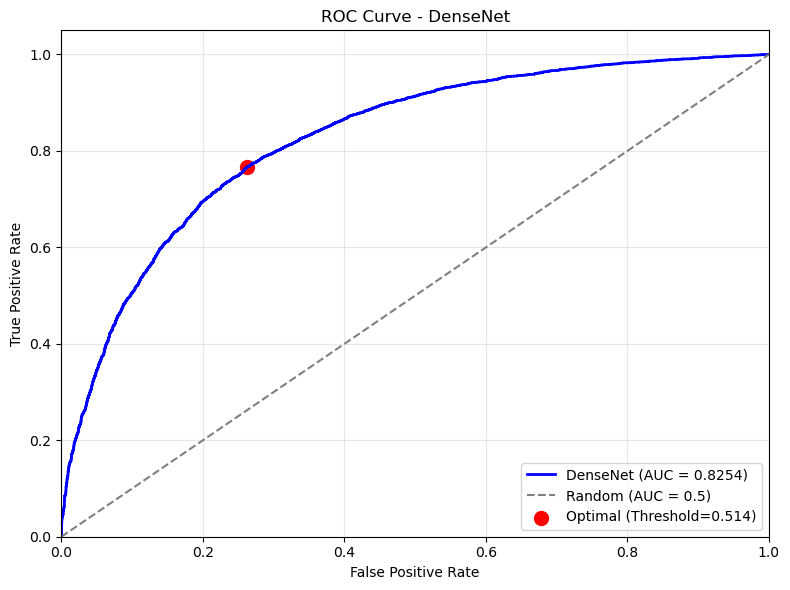

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_curve, auc

# 1. Lấy predictions probabilities (chưa threshold)
# Đảm bảo dùng model.predict lại để lấy xác suất
y_pred_prob = model.predict(test_gen, steps=test_steps, verbose=True)

# 2. Flatten nếu cần
if len(y_pred_prob.shape) > 1 and y_pred_prob.shape[1] == 1:
    y_pred_prob = y_pred_prob.ravel()

# 3. Cắt cho khớp với test_labels (giống như bạn đã làm với predictions)
min_length = min(len(test_labels), len(y_pred_prob))
y_test_roc = test_labels[:min_length].copy()  # Tạo bản sao để không ảnh hưởng biến cũ
y_pred_prob = y_pred_prob[:min_length]

print(f"\nROC Analysis:")
print(f"y_test shape for ROC: {y_test_roc.shape}")
print(f"y_pred_prob shape: {y_pred_prob.shape}")

# 4. Tính ROC curve
fpr, tpr, thresholds = roc_curve(y_test_roc, y_pred_prob)
roc_auc = auc(fpr, tpr)

# 5. Tìm điểm tối ưu (Youden's J)
youden_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[youden_idx]
optimal_fpr = fpr[youden_idx]
optimal_tpr = tpr[youden_idx]

# 6. Vẽ ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'DenseNet (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random (AUC = 0.5)')
plt.scatter(optimal_fpr, optimal_tpr, color='red', s=100, 
           label=f'Optimal (Threshold={optimal_threshold:.3f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - DenseNet')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 7. Lưu ROC data vào CSV
roc_points_df = pd.DataFrame({
    'FPR': fpr,
    'TPR': tpr,
    'Threshold': thresholds
})
roc_points_df.to_csv('ROC_curve_points_efficientnet.csv', index=False)

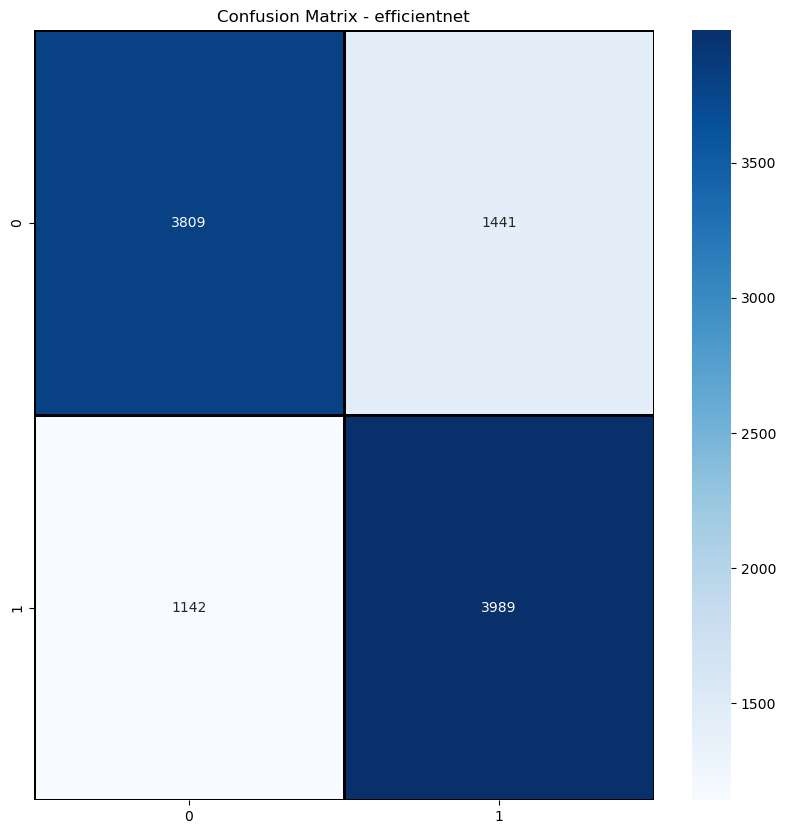

In [30]:
# DenseNet
cm = confusion_matrix(test_labels, predictions)
cm
cm = pd.DataFrame(cm, index=['0', '1'], columns=['0', '1'])
# DenseNet
plt.figure(figsize=(10, 10))
sns.heatmap(cm, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='d', xticklabels=cm.columns, yticklabels=cm.index)
plt.title('Confusion Matrix - efficientnet')
plt.show()